In [220]:
import pathlib
import numpy as np
from scipy import stats, signal, fft
from scipy.optimize import curve_fit
from scipy.ndimage import convolve
import seaborn as sns
import matplotlib.pyplot as plt
import cv2

from PIL import Image

## Data-Handling

In [215]:
DATA_DIR = 'datasets_for_Statistician/Latent2048_19_Jul_2023_7'
# DATA_DIR = 'data_map_cutouts/train_50_2_npy/Primary_train/generated_data/'
BATCH_SIZE = 256
TOTAL_NO_IMAGES = 400

## Visualization

Shape of images from dataLoader: (128, 128)


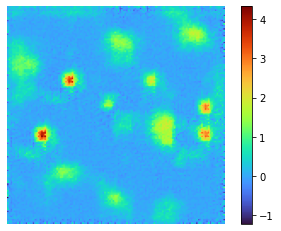

In [216]:
# Sampling from the dataset
# Choosing the index of the image to read
image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

# Reading the image
images = np.load(image_path)
# If you want to add a Gaussian blur
# images = cv2.GaussianBlur(images, (3,3), 0)

# Printing the shape of the image (for error-catching manually)
print("Shape of images from dataLoader:", images.shape)

# Displaying a sample input image
plt.imshow(images, cmap = 'turbo') # This is a nice cmap to use
plt.axis('off')
plt.colorbar()
plt.show()

## Plotting the Intensity distribution

(16384, 128)


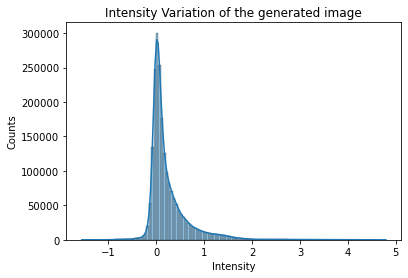

In [217]:
# Reading the first 127 images to make the intensity distribution
for i in range(127):
    image_indx = i
    image_path = DATA_DIR + '/' + str(image_indx) + '.npy'
    temp_images = np.load(image_path)

    images = np.concatenate([images, temp_images], axis = 0)

# Reshaping to make it a vector (because seaborn will take a vector to histplot)
images = np.reshape(images, (-1,))

# Use seaborn to plot the intensity distribution
sns.histplot(images, kde=True, binwidth=0.05) # Choosing binwidth 0.05 for uniformity

# Set plot labels
plt.xlabel('Intensity')
plt.ylabel('Counts')
plt.title("Intensity Variation of the generated image")
# plt.xlim([0, 1.])

# Show the plot
plt.show()

## Plotting the marginal distributions

In [196]:
# Define the Gaussian function
def gaussian_with_mean(x, amplitude, mean, variance):
    return amplitude * np.exp(-(np.abs(x - mean) ** 2) / (2 * variance))

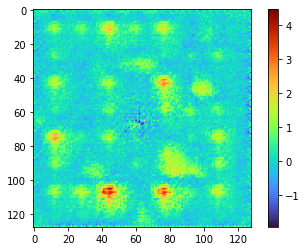

----Best-fit parameters---
Amplitude: 40.035806022966604
Mean: 139.31490139584437
Variance: 9247.456001748966


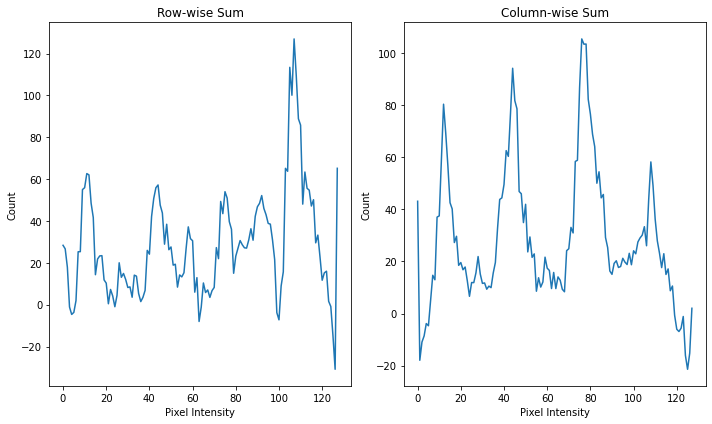

In [197]:
# Selecting the image index
image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

# Reading the image
image = np.load(image_path)

# If you want to add a gaussian Blur
# images = cv2.GaussianBlur(images, (7,7), 0)

# Calculate the row-wise and column-wise histograms
row_hist = np.sum(image, axis=1)
col_hist = np.sum(image, axis=0)

# Visualizing the image itself
plt.imshow(image, cmap='turbo')
plt.colorbar()
plt.show()

# Create subplots for row and column histograms
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot row-wise histogram
axes[0].plot(row_hist)
x = np.arange(row_hist.size)

        # Fit the Gaussian curve to the data
initial_guess = [1, 0., 10]  # Initial parameter guesses for the fit
        # try:
optimized_parameters, _ = curve_fit(gaussian_with_mean, x, row_hist, p0=initial_guess, maxfev=1000000)

                # Extract the optimized parameter values
amplitude_opt, mean_opt, var_opt = optimized_parameters
print("----Best-fit parameters---")
print("Amplitude:", amplitude_opt)
print("Mean:", mean_opt)
print("Variance:", var_opt)

                # Generate the best-fit Gaussian curve using the optimized parameters
y_fit = gaussian_with_mean(x, amplitude_opt, mean_opt, var_opt)
                
# axes[0].plot(y_fit)
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Count')
axes[0].set_title('Row-wise Sum')

# Plot column-wise histogram
axes[1].plot(col_hist)
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Count')
axes[1].set_title('Column-wise Sum')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Counting the average number of peaks per image

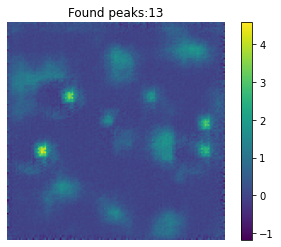

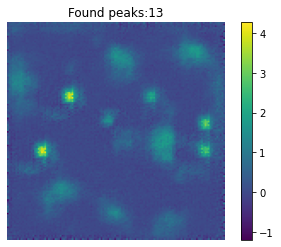

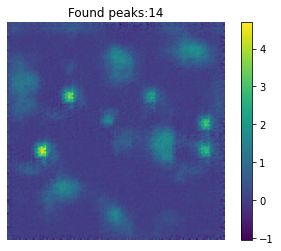

Found: 3389


In [218]:
# This is a bad way of doing this, because it misses the peaks a lot 
    # (13 found instead of the input images of 50 blobs each)

from skimage.feature import peak_local_max
# images, _ = next(iter(dataLoader))
# images = images.detach().cpu().numpy()

peak_area_list = []
for i in range(BATCH_SIZE):

    # Need to remove the streaks

    image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
    image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

    image = np.load(image_path)

    # grey = cv2.convertScaleAbs(image * 255)

    # _, binary = cv2.threshold(grey, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    # # Perform morphological operations to remove streaks
    # kernel = np.ones((7,7), np.uint8)
    # opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)

    # # Invert the binary image to create a mask for the streaks
    # mask = 255 - opening
    # # Apply the mask to the original image
    # result = cv2.bitwise_and(grey, grey, mask=mask)

    
    # Define the minimum peak height and minimum distance between peaks
    min_peak_height = 0.
    min_peak_distance = 10

    # Find all the peaks in the image
    peaks = peak_local_max(image=image - np.min(image), 
                           min_distance=min_peak_distance, 
                           threshold_abs=min_peak_height)
    for peak in peaks:
        min_x = peak[0] - 10
        min_y = peak[1] - 10
        max_x = peak[0] + 11
        max_y = peak[1] + 11
        
        peak_area_list.append(image[min_x:max_x, min_y:max_y])

    if i % 100 == 0:
        # plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title("Found peaks:" + str(peaks.shape[0]))
        plt.axis('off')
        plt.colorbar()

        # plt.subplot(1,2,2)
        # plt.imshow(grey)
        # plt.axis('off')
        # plt.colorbar()
        plt.show()


print("Found:", len(peak_area_list))

In [214]:
# Trying to use star-apperture finders to find the sources/blobs
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats

image = np.load(DATA_DIR + '/123.npy')

_, _, sigma = sigma_clipped_stats(image, sigma=1.50)
daofind = DAOStarFinder(fwhm=3.0, threshold=5*sigma)  
sources = daofind(image) 
print(sources)

 id      xcentroid       ...        flux                mag         
--- -------------------- ... ------------------ --------------------
  1    6.930606644874522 ...  1.198664665222168 -0.19674425797070033
  2    71.41969090618123 ... 1.0198239088058472 -0.02131297343422664
  3   119.32114014924987 ... 1.0610692501068115   -0.064359322047946
  4   11.007001648445083 ... 1.0495448112487793 -0.05250246475819162
  5    55.10023260471868 ... 1.3392306566238403 -0.31713845573396027
  6    83.47168845792964 ...  1.018574833869934 -0.01998235443243216
  7 -0.16191411123094251 ... 1.6079195737838745  -0.5156608051613765
  8   128.21977294039752 ... 1.4708068370819092 -0.41888910007535685
  9   12.032020170206614 ... 1.4845269918441772  -0.4289702459928612
 10   41.927779439186985 ... 2.4569201469421387  -0.9759776039536067
...                  ... ...                ...                  ...
123   24.386333802367673 ... 1.6902068853378296  -0.5698496663588974
124    33.32836176880655 ... 2.287

50/50, 1.4080050007293186

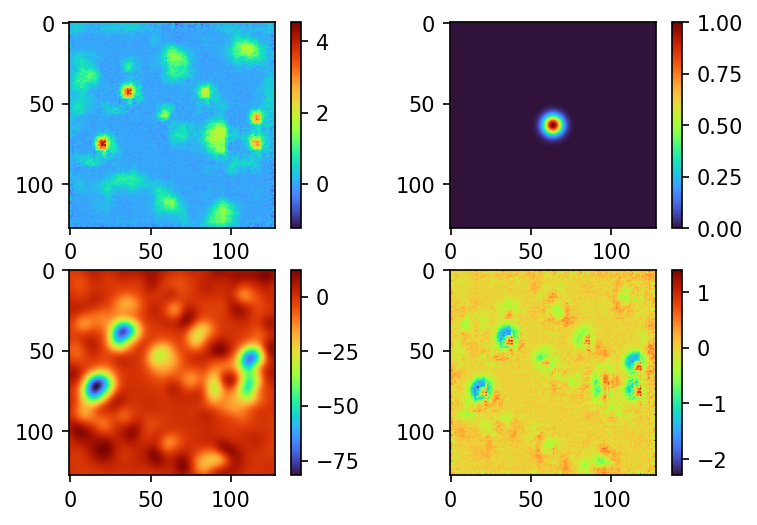

50


In [223]:
x = np.linspace(0, 1, 128)
y = np.linspace(0, 1, 128)
X, Y = np.meshgrid(x, y)
a = np.vstack((X.ravel(), Y.ravel())).T
def make_blob(mean, var=1):
    return stats.multivariate_normal.pdf(a, mean=mean, cov=var * 1e-3).reshape((128, 128))

filter_gaussian = make_blob((0.5, 0.5))
filter_gaussian = filter_gaussian / np.max(filter_gaussian)
plt.figure(dpi=150)
plt.subplot(2,2,1)
plt.imshow(image, cmap='turbo')
plt.colorbar()

plt.subplot(2,2,2)
plt.imshow(filter_gaussian, cmap='turbo')
plt.colorbar()

image_temp = np.copy(image)

peak_pos = []
count = 0

while np.max(image_temp > 0.5) and count < 50:
    count += 1
    print(f'\r{count}/50, {np.max(image_temp)}', end='')
    result = convolve(image_temp, filter_gaussian, mode = 'constant', cval=0.)
    pos_max = np.argmax(result)
    x = pos_max // 128
    y = pos_max % 128
    peak_pos.append([x,y])
    a_max = result[x,y] / 52.26614518050251
    a_max = image_temp[x, y]

    to_remove = make_blob((y/128, x/128))
    to_remove = to_remove / np.max(to_remove)
    to_remove = to_remove * a_max

    image_temp = image_temp - to_remove

plt.subplot(2,2,3)
plt.imshow(result, cmap='turbo')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(image_temp, cmap='turbo')
plt.colorbar()
plt.show()

print(count)

In [225]:
peak_pos.sort()
for [x,y] in peak_pos:
    print(x,y)

2 25
2 36
2 42
3 5
5 101
16 60
16 109
18 116
20 100
22 7
22 65
22 71
24 120
25 37
29 67
33 10
33 16
34 64
38 5
42 36
42 123
43 84
49 6
54 5
54 25
56 59
58 116
64 94
69 69
69 78
70 91
74 115
75 20
77 92
78 119
79 93
87 11
88 103
88 113
97 35
99 43
101 24
102 52
111 21
111 61
116 66
119 94
120 98
121 98
124 86


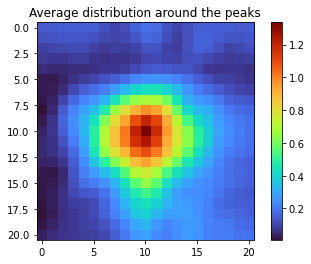

In [199]:
peak_avg = np.zeros((21, 21))
if len(peak_area_list) > 0: 
    for peak_area in peak_area_list:
        peak_avg += peak_area

    peak_avg = cv2.GaussianBlur(peak_avg, (3,3), 0)
    plt.imshow(peak_avg/len(peak_area_list), cmap='turbo')
else:
    plt.imshow(peak_avg)
plt.colorbar()
plt.title("Average distribution around the peaks")
plt.show()

In [200]:
# Define the Gaussian function
def gaussian(x, amplitude, variance):
    return amplitude * np.exp(-((x) ** 2) / (2 * variance))


In [201]:
def get_radial_dist(image = np.ones((21,21)), width=21, title='Intensity variation', best_fit=True):
    center = np.array([(width + 1) //2, (width + 1) // 2])
    # print("Center:", center)

    intensity_map = np.zeros(shape=(int(np.ceil(((width + 1 )// 2) * np.sqrt(2)))))
    counts = np.copy(intensity_map)

    for i in range(width):
        for j in range(width):
            pos = np.array([i, j])
            # print(pos)
            radius = int(np.linalg.norm(center - pos))
            # print(radius)
            intensity_map[radius] += image[i, j]
            counts[radius] += 1
    
    intensity_map = intensity_map / counts


    plt.plot(intensity_map)
    
    if best_fit:
        x = np.arange(intensity_map.size)
        # print(x, intensity_maps)

        # Fit the Gaussian curve to the data
        initial_guess = [1, 1.]  # Initial parameter guesses for the fit
        # try:
        optimized_parameters, _ = curve_fit(gaussian, x, intensity_map - np.min(intensity_map), p0=initial_guess, maxfev=1000000)

                # Extract the optimized parameter values
        amplitude_opt, var_opt = optimized_parameters
        print("----Best-fit parameters---")
        print("Amplitude:", amplitude_opt)
        # print("Mean:", mean_opt)
        print("Variance:", var_opt)

                # Generate the best-fit Gaussian curve using the optimized parameters
        y_fit = gaussian(x, amplitude_opt, var_opt) + np.min(intensity_map)
                
        plt.plot(y_fit)
        # except:
        #     print("ERROR: Best-fit Gaussian not found")
        # print(counts[0], counts[-1])
        plt.legend(['True intensity variation', 'Best-fit Gaussian'])
    plt.title(title)
    plt.show()

    return intensity_map

----Best-fit parameters---
Amplitude: 1.015273011430406
Variance: 10.967474189119498


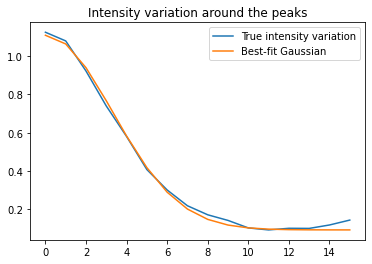

array([1.12442689, 1.07921887, 0.92212595, 0.73966837, 0.58065145,
       0.40814969, 0.30160339, 0.21937224, 0.17226199, 0.14291391,
       0.10378204, 0.09339014, 0.10184679, 0.1012907 , 0.11912741,
       0.1446895 ])

In [202]:
get_radial_dist(peak_avg / len(peak_area_list), title='Intensity variation around the peaks')

In [203]:
print("Average no. of peaks per image:", len(peak_area_list)/BATCH_SIZE)

Average no. of peaks per image: 23.78515625


In [204]:
# Clean-up
del peak_area_list, peak_avg, peak, peak_area, peaks

## Image fft

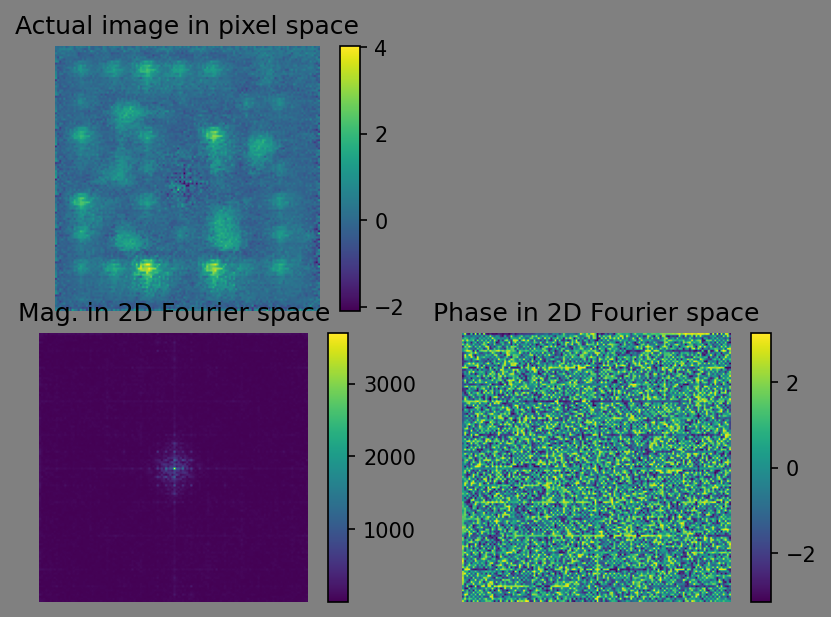

In [205]:
image_indx = np.random.randint(0, TOTAL_NO_IMAGES)
image_path = DATA_DIR + '/' + str(image_indx) + '.npy'

image = np.load(image_path)

# images = images - np.mean(images)

images_fft = fft.fftshift(fft.fft2(image))

images_fft_abs = np.abs(images_fft)

images_fft_abs[np.angle(images_fft) < -np.pi / 2] *= -1
images_fft_abs[np.angle(images_fft) > np.pi / 2] *= -1

plt.figure(constrained_layout = True, dpi=150, facecolor='0.5')

# images_fft_abs = np.sum(images_fft_abs, axis=0)
plt.subplot(2,2,1)
plt.imshow(image)
plt.colorbar()
plt.title("Actual image in pixel space")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow((np.abs(images_fft[ :, :])))
plt.colorbar()
plt.title("Mag. in 2D Fourier space")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(np.angle(images_fft[:, :]))
plt.colorbar()
plt.title("Phase in 2D Fourier space")
plt.axis('off')

plt.show()

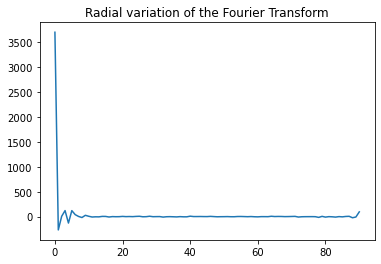

array([ 3.69324121e+03, -2.66227234e+02,  7.08604431e+00,  1.20880501e+02,
       -1.28800625e+02,  1.20063730e+02,  3.95964097e+01,  3.21850348e+00,
       -1.79267285e+01,  2.64205711e+01,  7.04668847e+00, -7.71405572e+00,
       -3.57727956e+00, -4.71742368e+00,  4.59463965e+00,  3.73077888e+00,
       -7.71435174e+00,  4.30058956e-01, -1.78096057e+00, -9.31979374e-01,
        4.40264330e+00, -7.36150742e-02,  2.02736821e+00, -2.91007451e-01,
        4.37783539e+00,  6.96650079e+00, -2.86608511e+00, -1.00763685e+00,
        7.76038116e+00, -1.32758285e+00,  5.00944168e-02,  1.05548650e+00,
       -9.32171218e+00, -2.25550389e+00, -6.42234639e-01, -3.07413398e+00,
       -5.66241767e+00, -1.93005153e-01, -3.91758329e+00, -3.78272234e+00,
        8.66900179e+00,  1.33315569e+00,  1.39220684e+00,  2.46760017e+00,
        9.07946535e-01,  5.32683800e-01,  4.99069095e+00,  6.76264720e-01,
       -3.02760650e+00, -1.32298279e+00, -7.74008922e-01,  6.19469261e-01,
       -1.96564247e+00, -

In [206]:
get_radial_dist(image = images_fft_abs[:, :], 
                width = 128, 
                best_fit = False, 
                title = 'Radial variation of the Fourier Transform')

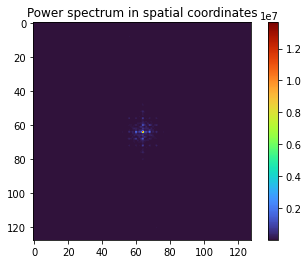

In [207]:
power_spectrum = np.abs(np.conj(images_fft) * images_fft)
plt.imshow((power_spectrum[:, :]), cmap='turbo')
plt.colorbar()
plt.title("Power spectrum in spatial coordinates")
plt.show()